# Notes
* Rows are *not* deleted from `cx_translations` when the translation drafts are purged

In [96]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from wmfdata import charting, hive
from wmfdata.utils import pd_display_all

In [97]:
charting.set_mpl_style()

In [160]:
CHART_START = "2018-07"
MWH_SNAPSHOT = "2019-08" # This will also be the end of the charts
TARGET_WIKIS = ("mlwiki", "bnwiki", "tlwiki", "jvwiki", "mnwiki")

time_range = pd.period_range(CHART_START, MWH_SNAPSHOT, freq="W-MON")
time_end = time_range[-1].to_timestamp(how="end")

# If the last week goes past the end of mediawiki_history, remove it
if time_end > pd.Timestamp(MWH_SNAPSHOT):
    time_range = time_range[:-1]
    time_start = time_range[0].to_timestamp(how="start")
    time_end = time_range[-1].to_timestamp(how="end")
    
query_params = {
    "MWH_SNAPSHOT": MWH_SNAPSHOT,
    "time_start": time_start,
    "time_end": time_end
}

In [162]:
translations = hive.run("""
select
    event_user_text as translator,
    wiki_db as wiki,
    date_format(event_timestamp, "yyyy-MM-dd") as date,
    if(array_contains(revision_tags, "contenttranslation-v2"), 2, 1) as cx_version,
    if(
        coalesce(datediff(event_timestamp, ssac.dt) > 252, true), -- 6 months ≈ 26 weeks = 252 days
        "experienced",
        "new"
    ) as user_experience,
    if(revision_is_deleted_by_page_deletion, "deleted", "surviving") as status
from wmf.mediawiki_history mh
left join event_sanitized.serversideaccountcreation ssac
on
    ssac.event.username = event_user_text and
    ssac.year >= 0
where
    mh.snapshot = "{MWH_SNAPSHOT}" and
    mh.event_timestamp between "{time_start}" and "{time_end}" and
    event_entity = "revision" and
    event_type = "create" and
    array_contains(revision_tags, "contenttranslation")
""".format(**query_params)
).assign(
    date=lambda df: pd.to_datetime(df["date"])
).assign(
    week=lambda df: df["date"].dt.to_period("W-MON").dt.to_timestamp()
)

In [120]:
translations[translations["translator"].isnull()]

,translator,wiki,date,cx_version,user_experience,status,week
0,None,enwiki,2018-07-20,1,experienced,surviving,2018-07-17
1,None,enwiki,2018-07-20,1,experienced,surviving,2018-07-17
2,None,fiwiki,2019-01-16,1,experienced,surviving,2019-01-15
3,None,cawiki,2018-07-02,1,experienced,surviving,2018-06-26
4,None,enwiki,2019-08-26,2,experienced,surviving,2019-08-20
5,None,hewiki,2019-07-04,2,experienced,surviving,2019-07-02
6,None,idwiki,2018-08-20,1,experienced,deleted,2018-08-14
7,None,hewiki,2019-04-17,2,experienced,surviving,2019-04-16
8,None,hewiki,2019-06-10,2,experienced,surviving,2019-06-04
9,None,zhwiki,2019-04-05,2,experienced,surviving,2019-04-02


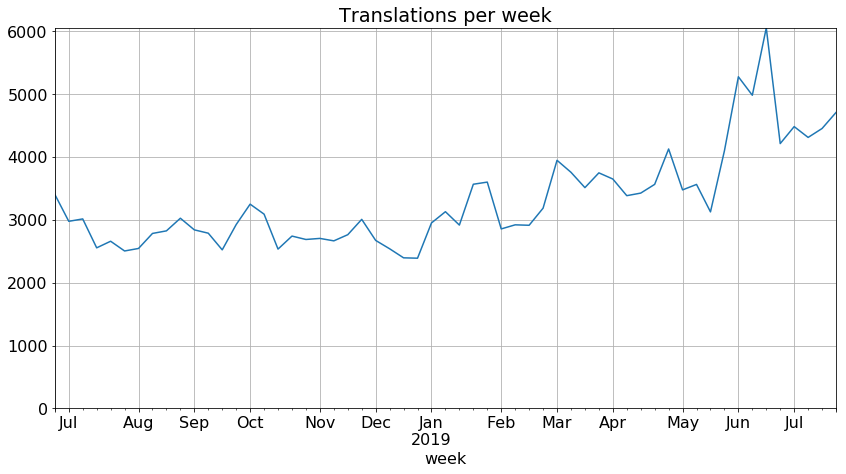

In [163]:
translations.groupby("week").size().plot(ylim=0)
plt.title("Translations per week");

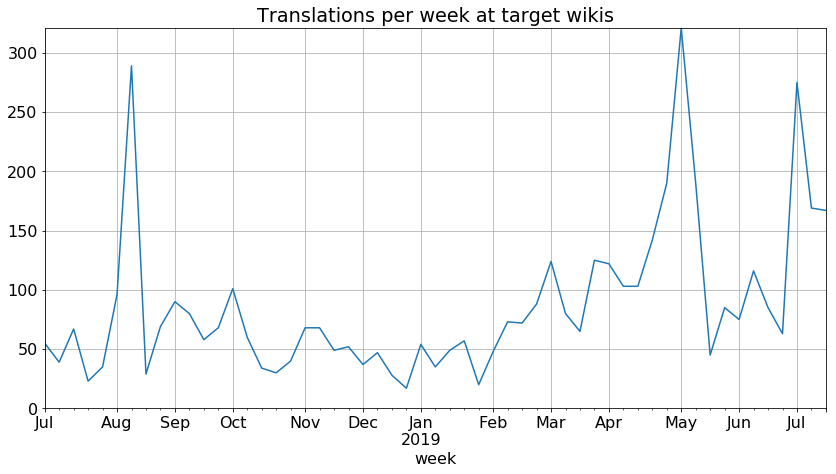

In [166]:
translations.query("wiki in @TARGET_WIKIS").groupby("week").size().iloc[1:-1].plot(ylim=0)
plt.title("Translations per week at target wikis");

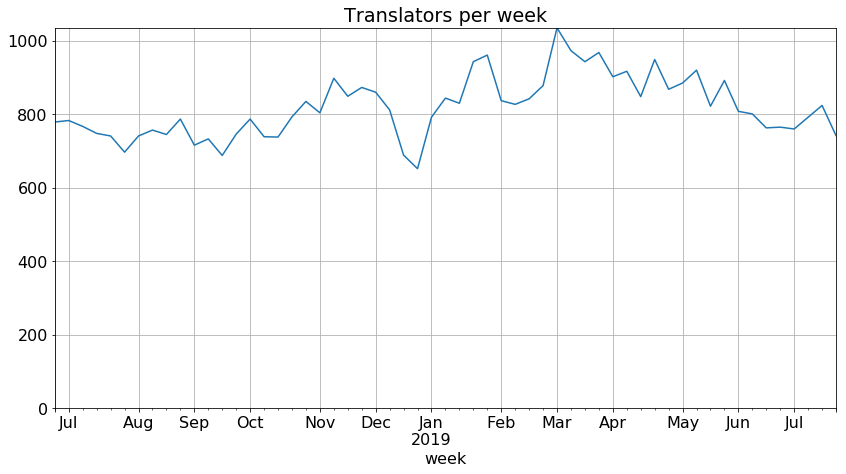

In [170]:
translators_per_week = translations.groupby("week").nunique()["translator"]
translators_per_week.plot(ylim=0)
plt.title("Translators per week");

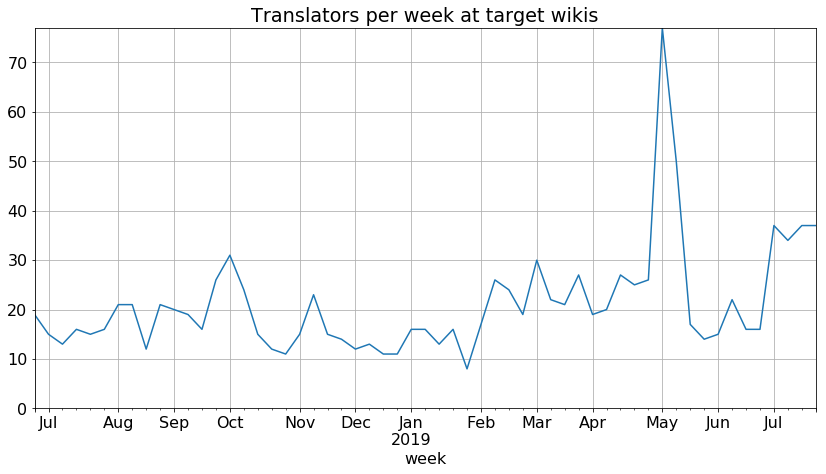

In [171]:
weekly_target_wiki_translators = translations.query("wiki in @TARGET_WIKIS").groupby("week").nunique()["translator"]
weekly_target_wiki_translators.plot(ylim=0)
plt.title("Translators per week at target wikis");

In [108]:
translations_by_version = translations.groupby(["week", "cx_version"]).size().unstack().fillna(0)

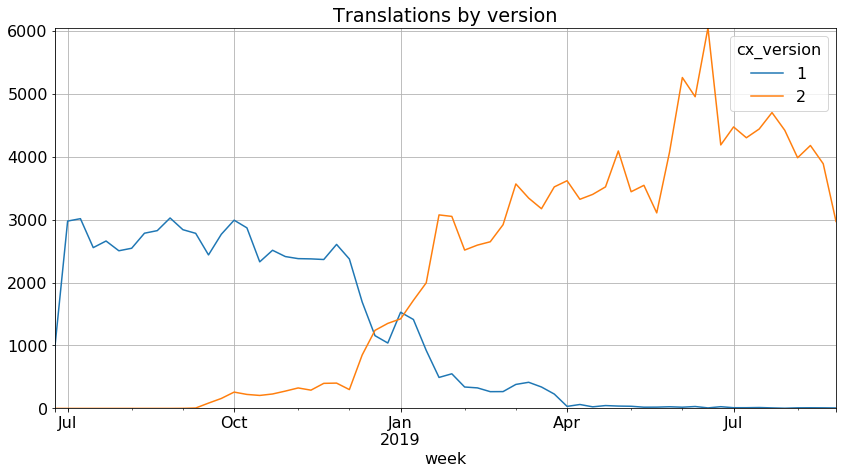

In [172]:
translations_by_version.plot(ylim=0)
plt.title("Translations by version");

In [91]:
ch = chartify.Chart(x_axis_type='datetime')
ch.set_title("Translations by version")
ch.plot.area(
    data_frame=translations_by_version,
    x_column='week',
    y_column="translations",
    color_column='cx_version',
    stacked=True
)
ch.show("html")

# Surviving translations by newcomers

https://phabricator.wikimedia.org/T194650

In [4]:
translation_counts = translation_counts[translation_counts.month < '2019-07']
translation_counts

,month,cx_version,user_experience,status,n_translations
0,2018-07,1,experienced,deleted,454
1,2018-07,1,experienced,survived,9371
2,2018-07,1,new,deleted,385
3,2018-07,1,new,survived,2341
4,2018-08,1,experienced,deleted,551
5,2018-08,1,experienced,survived,8714
6,2018-08,1,new,deleted,419
7,2018-08,1,new,survived,2307
8,2018-09,1,experienced,deleted,523
9,2018-09,1,experienced,survived,8942


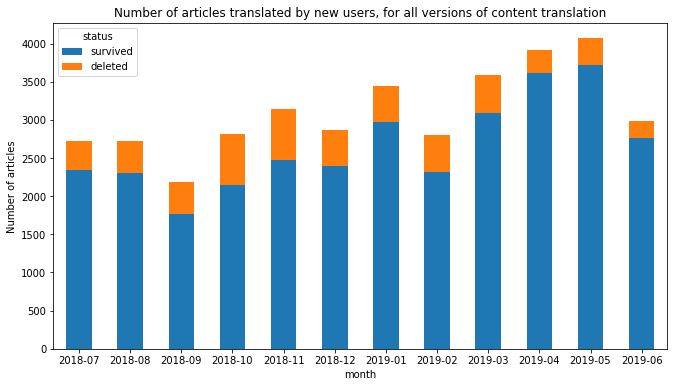

In [5]:
new_all_version = translation_counts[translation_counts.user_experience == 'new'] \
                  .groupby(['month', 'status'], as_index = False)['n_translations'] \
                  .sum() \
                  .pivot(index='month', columns='status', values='n_translations')
fig = new_all_version.loc[:,['survived','deleted']].plot.bar(stacked=True, figsize=(11, 6))
fig.tick_params(axis = 'x', labelrotation=0)
fig.set_ylabel('Number of articles')
fig.set_title('Number of articles translated by new users, for all versions of content translation')
fig.get_figure().savefig('figures/translation_counts_new_all_version.png', dpi=300)

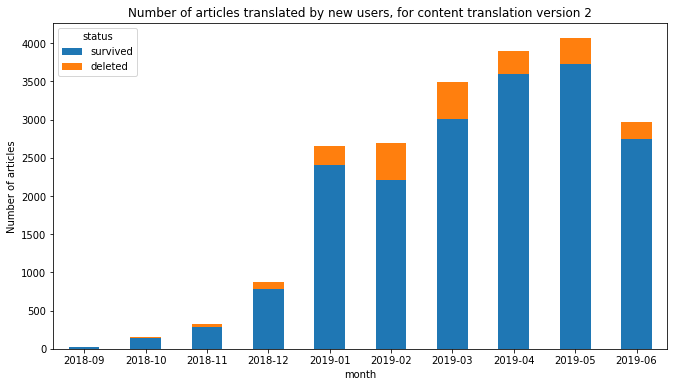

In [6]:
new_version2 = translation_counts[(translation_counts.user_experience == 'new') & (translation_counts.cx_version == 2)] \
               .groupby(['month', 'status'], as_index = False)['n_translations'] \
               .sum() \
               .pivot(index='month', columns='status', values='n_translations')
fig = new_version2.loc[:,['survived','deleted']].plot.bar(stacked=True, figsize=(11, 6))
fig.tick_params(axis = 'x', labelrotation=0)
fig.set_ylabel('Number of articles')
fig.set_title('Number of articles translated by new users, for content translation version 2')
fig.get_figure().savefig('figures/translation_counts_new_version2.png', dpi=300)

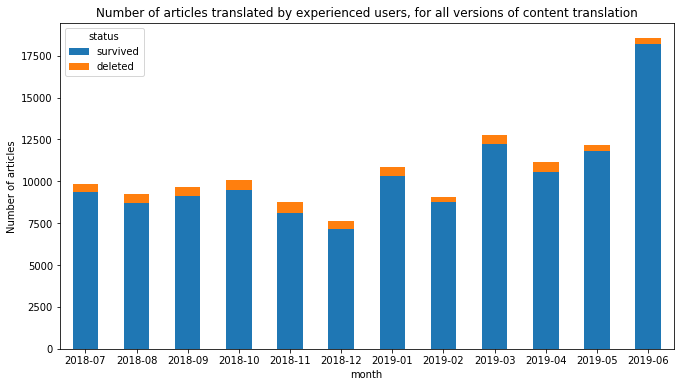

In [7]:
exp_all_version = translation_counts[translation_counts.user_experience == 'experienced'] \
                  .groupby(['month', 'status'], as_index = False)['n_translations'] \
                  .sum() \
                  .pivot(index='month', columns='status', values='n_translations')
fig = exp_all_version.loc[:,['survived','deleted']].plot.bar(stacked=True, figsize=(11, 6))
fig.tick_params(axis = 'x', labelrotation=0)
fig.set_ylabel('Number of articles')
fig.set_title('Number of articles translated by experienced users, for all versions of content translation')
fig.get_figure().savefig('figures/translation_counts_exp_all_version.png', dpi=300)

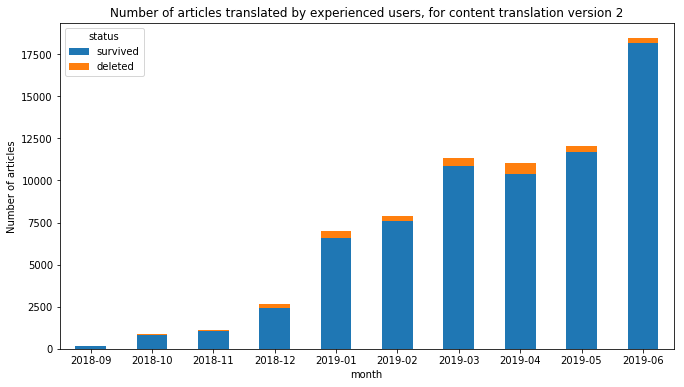

In [8]:
exp_version2 = translation_counts[(translation_counts.user_experience == 'experienced') & (translation_counts.cx_version == 2)] \
               .groupby(['month', 'status'], as_index = False)['n_translations'] \
               .sum() \
               .pivot(index='month', columns='status', values='n_translations')
fig = exp_version2.loc[:,['survived','deleted']].plot.bar(stacked=True, figsize=(11, 6))
fig.tick_params(axis = 'x', labelrotation=0)
fig.set_ylabel('Number of articles')
fig.set_title('Number of articles translated by experienced users, for content translation version 2')
fig.get_figure().savefig('figures/translation_counts_exp_version2.png', dpi=300)

# Translators

In [67]:
translators = mariadb.run("""
select
    month,
    cx_version,
    user_experience,
    count(distinct user_name) as users_starting_translations
from (
    select
        date_format(str_to_date(translation_start_timestamp, "%Y%m%d%H%i%S"), "%Y-%m") as month,
        translation_cx_version as cx_version,
        if(
            datediff(
                str_to_date(translation_start_timestamp, "%Y%m%d%H%i%S"),
                -- For old accounts, this is when the user account was centralized, but since we're looking
                -- post-2017 only, the distiction doesn't matter
                str_to_date(gu_registration, "%Y%m%d%H%i%S")
            ) > 252,
            "experienced",
            "new"
        ) as user_experience,
        gu_name as user_name
    from
        wikishared.cx_translations
    left join
        centralauth.globaluser
    on gu_id = translation_started_by
    where 
        translation_start_timestamp > "2018"
) translators
group by
    month,
    cx_version,
    user_experience
""")

In [68]:
translators.head()

,month,cx_version,user_experience,users_starting_translations
0,2018-01,1,experienced,2261
1,2018-01,1,new,1275
2,2018-01,2,experienced,3
3,2018-01,2,new,1
4,2018-02,1,experienced,2017


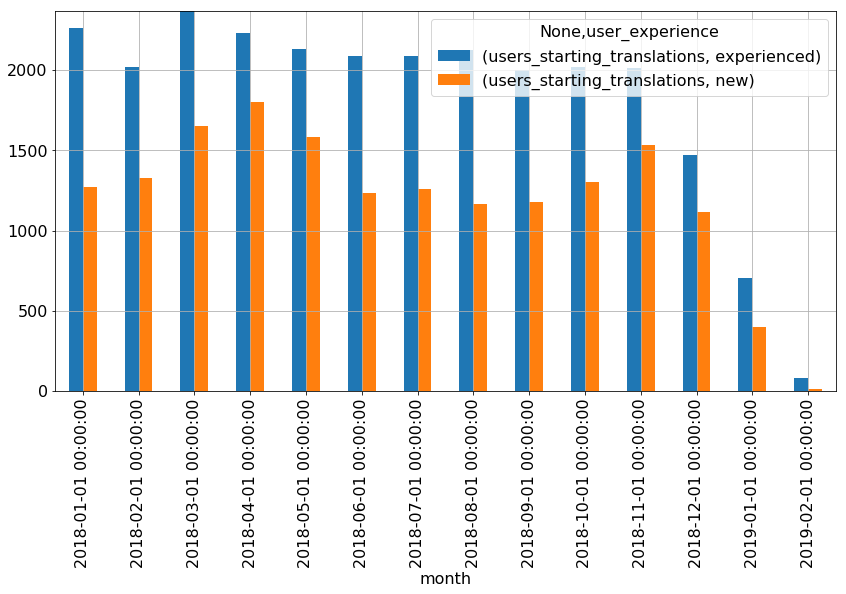

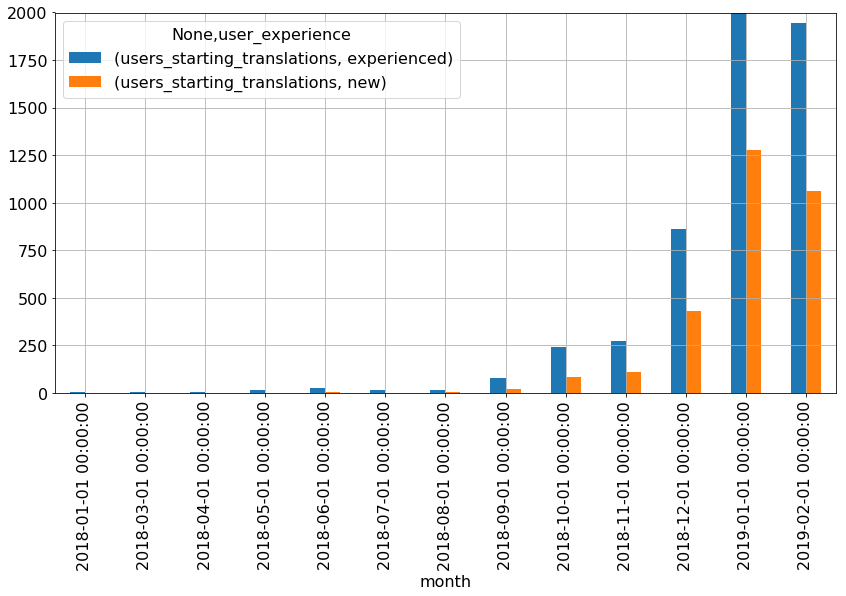

In [71]:
translators_cx1 = translators.query("cx_version == 1")
translators_cx2 = translators.query("cx_version == 2")

dfs = [translators_cx1, translators_cx2]

for df in dfs:
    (
        df
        .drop(["cx_version"], axis=1)
        .assign(month=lambda df: pd.to_datetime(df["month"]))
        .set_index(["month", "user_experience"])
        .unstack()
        .plot.bar()
    )

# Publication rate

The "token" in CX event logging is the user name... 😛

In [ ]:
mariadb.run("""
select
    date_format(str_to_date(translation_start_timestamp, "%Y%m%d%H%i%S"), "%Y-%m") as month,

wikishared.cx_translation


""")

Have to query the cx_translation table, get the output, and upload it to Hive so I can combine it with publishing failure data from event_logging.

In [ ]:
hive.run("drop table neilpquinn.cx_translators")

In [ ]:
path = "data/cx_translators.csv"
translators.to_csv(path)
hive.load_csv(
    path,
    field_spec="start_month string, user_name string, cx_version int",
    db_name = "neilpquinn",
    table_name="cx_translators"
)

In [ ]:
translators_stats = """


"""